In [6]:

import pyopencl as cl
#os.environ['SAS_OPENCL']='cuda:0' 
#os.environ['SAS_COMPILER']="unix"
cl.create_some_context()

<pyopencl.Context at 0x56012211ced0 on <pyopencl.Device 'Quadro RTX 5000' on 'NVIDIA CUDA' at 0x56011e0f5b10>>

In [7]:
import numpy as np
import h5py
import sasmodels
import sasmodels.core as core
import sasmodels.direct_model as direct_model
import time
import matplotlib.pyplot as plt

In [80]:

class Hdf:
    def __init__(self,output_id, folder, shape, *args):
        self.outputFile = folder + output_id +'.nxs'
        self.shape = shape
        self.__create_parameters(*args)
        self.__init_sas_model()
        self.__create_structure()

    def __create_structure(self):
        with h5py.File(self.outputFile, "w") as f:
            entry = f.create_group("entry")
            q = entry.create_dataset("qx", data=self.qx_sas, dtype='f')
            q.attrs['units'] = 'nm-1'
            I = entry.create_dataset("I", data=self.I_sas, dtype='f')
            I.attrs['units'] = 'm-1 sr-1'
            I_noisy = entry.create_dataset("I_noisy", data=self.I_noisy, dtype='f')
            I_noisy.attrs['units'] = 'm-1 sr-1'
            properties = f.create_group("properties")
            size = properties.create_dataset('size', data = self.size, dtype= 'i')
            size.attrs['units'] = 'nm'
            shape = properties.create_dataset('shape',data = self.shape)

            '''radius = properties.create_dataset('radius',data = self.parameters_dict['radius'], dtype='f')
            radius.attrs['units'] = 'nm'
            background = properties.create_dataset('background',data = self.parameters_dict['background'], dtype='f')
            sld = properties.create_dataset('sld',data = self.parameters_dict['sld'], dtype='f')
            sld_solvent = properties.create_dataset('sld_solvent',data = self.parameters_dict['sld_solvent'], dtype='f')
            radiu_pd = properties.create_dataset('radius_pd',data = self.parameters_dict['radius_pd'], dtype='f')
            radius_pd_type = properties.create_dataset('radius_pd_type',data = self.parameters_dict['radius_pd_type'])
            radius_pd_n = properties.create_dataset('radius_pd_n',data = self.parameters_dict['radius_pd_n'], dtype='f')'''

            for key in self.parameters_dict:
                properties.create_dataset(key, data = self.parameters_dict[key])

    def __create_parameters(self, *args):
        self.size = 10
        self.radius = -1
        while self.radius <0:
            self.radius = np.random.normal(loc = self.size*0.005, scale= self.size*0.01 ) 
        self.radius_polydispersity = -1 
        while self.radius_polydispersity <0:
            self.radius_polydispersity = np.random.normal(loc = 0.05, scale = 0.03)
        if self.shape == 'sphere':
            self.parameters_dict =  {'radius': self.radius, 
                                    'background':0., 
                                    'sld':1.,
                                    'sld_solvent':0.,
                                    'radius_pd': self.radius_polydispersity, 
                                    'radius_pd_type': 'gaussian', 
                                    'radius_pd_n': 35
            }
        elif self.shape == 'hardsphere':
            self.parameters_dict =  {'radius': self.radius, 
                                    'background':0., 
                                    'sld':1.,
                                    'sld_solvent':0.,
                                    'radius_pd': self.radius_polydispersity, 
                                    'radius_pd_type': 'gaussian', 
                                    'radius_pd_n': 35,
                                    'radius_effective' : self.radius,
                                    'volfraction' : np.round(args[0],2)
            }
        if self.shape == 'cylinder':
            self.length = -1
            while self.length<0:
                self.length = np.random.normal(loc = self.size*0.1, scale= self.size*0.01 )
            self.length_polydispersity = -1
            while self.length_polydispersity<0:
                self.length_polydispersity = np.random.normal(loc = 0.08, scale = 0.05)
            self.theta = 90
            self.phi = 0
            self.phi_distr = 'uniform'
            self.phi_pd = 4.5

            self.parameters_dict =  {'radius': self.radius, 
                                'background':0., 
                                'sld':1.,
                                'sld_solvent':0.,
                                'theta': self.theta,
                                'radius_pd': self.radius_polydispersity,
                                'radius_pd_type': 'gaussian', 
                                'radius_pd_n': 35,
                                'length':self.length,
                                'length_pd': self.length_polydispersity,
                                'length_pd_type':'gaussian',
                                'length_pd_n':35,
                                'phi':self.phi,
                                'phi_pd': self.phi_pd,
                                'phi_pd_type': self.phi_distr,
                                'phi_pd_n':10}



    def __init_sas_model(self):
        model = core.load_model(self.shape)
        self.qx_sas = np.linspace(-np.pi/self.size/2, np.pi/self.size/2, 512)

        q2y = self.qx_sas + 0* self.qx_sas[:,np.newaxis]
        q2z = self.qx_sas[:,np.newaxis] + 0* self.qx_sas
        q2y = q2y.reshape(q2y.size)
        q2z = q2z.reshape(q2z.size)
        kernel=model.make_kernel([q2y, q2z])
        modelParameters_sas = model.info.parameters.defaults.copy()
        modelParameters_sas.update(self.parameters_dict)
        self.I_sas = direct_model.call_kernel(kernel, modelParameters_sas)
        self.I_sas = self.I_sas.reshape(512,512)
        model.release()
        self.I_noisy = self.I_sas + np.random.poisson(self.I_sas) # adding some poison noise


In [73]:
st = time.time()
a=Hdf(f'{101:04}', '/home/slaskina/simulations/','hardsphere', 0.3)
print(time.time() - st)

0.027446870445775304
{'radius': 0.0707640832657312, 'background': 0.0, 'sld': 1.0, 'sld_solvent': 0.0, 'radius_pd': 0.027446870445775304, 'radius_pd_type': 'gaussian', 'radius_pd_n': 35, 'radius_effective': 0.0707640832657312, 'volfraction': 0.3}
0.03702950477600098


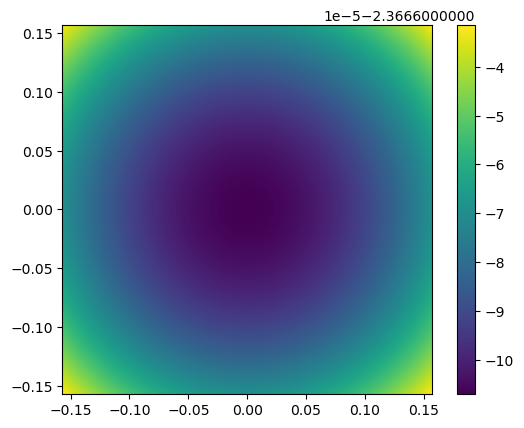

In [74]:

im = plt.imshow(np.log(a.I_sas), cmap = 'viridis', extent=[a.qx_sas.min(),a.qx_sas.max(),a.qx_sas.min(),a.qx_sas.max(),])
plt.colorbar(im)